In [9]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch
import torch.functional as F
import numpy as np
import torchvision
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

from models import UNet
from inference import resize
image_url = "./data/test/images/122021416441730-28_5_side2.jpg"

image = Image.open(image_url)
image = resize(image)
image = np.array(image)

rgb_img = np.float32(image) / 255
input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

ckpt = torch.load("./weights/base_best.pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=3, out_channels=7)
model.load_state_dict(ckpt['model'].float().state_dict())
model = model.eval()

model.to(device)
input_tensor = input_tensor.to(device)


output = model(input_tensor)
print(type(output))

<class 'torch.Tensor'>


In [10]:
class SegmentationModelOutputWrapper(torch.nn.Module):
    def __init__(self, model): 
        super(SegmentationModelOutputWrapper, self).__init__()
        self.model = model
        
    def forward(self, x):
        return self.model(x)
    
model = SegmentationModelOutputWrapper(model)
output = model(input_tensor)

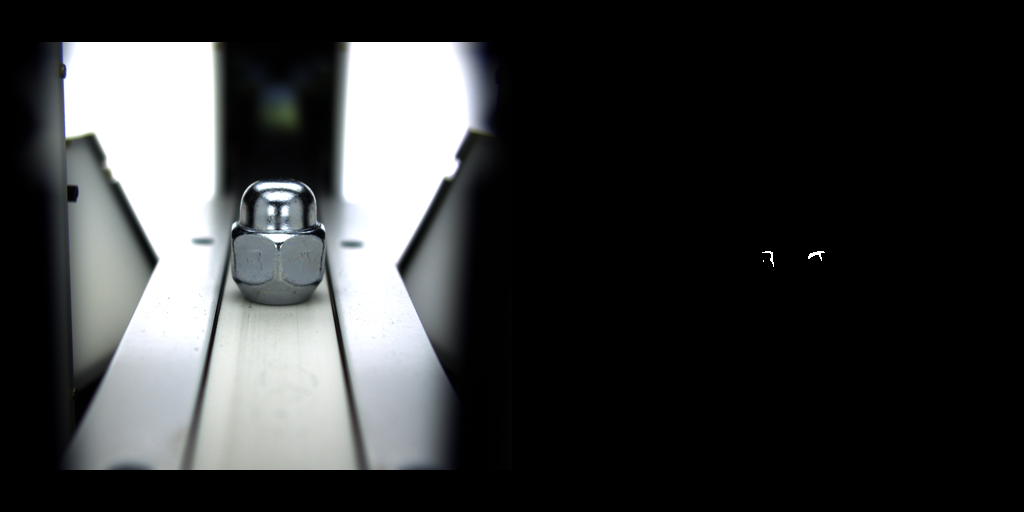

In [11]:
normalized_masks = torch.nn.functional.softmax(output, dim=1).cpu()
sem_classes = [' __background__', 'RED', 'GOLD', 'GLUE', 'STABBED', 'CLAMP', 'GREY']
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

target_category = sem_class_to_idx["CLAMP"]
target_mask = normalized_masks[0, :, :, :].argmax(axis=0).detach().cpu().numpy()
target_mask_uint8 = 255 * np.uint8(target_mask == target_category)
target_mask_float = np.float32(target_mask == target_category)

both_images = np.hstack((image, np.repeat(target_mask_uint8[:, :, None], 3, axis=-1)))
Image.fromarray(both_images)

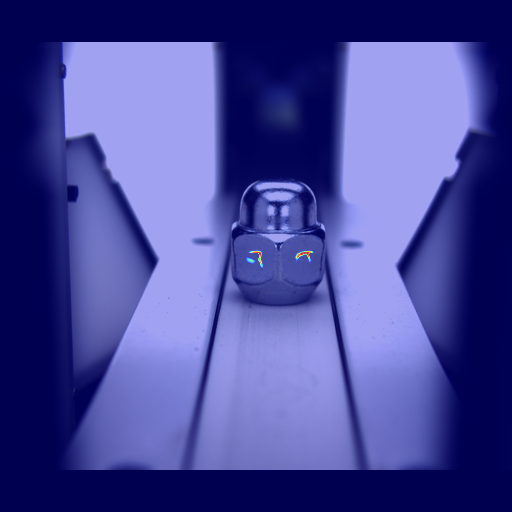

In [12]:
from pytorch_grad_cam import GradCAM

class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        self.mask = self.mask.to(device)
        
    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()

    
target_layers = [model.model.up4]
targets = [SemanticSegmentationTarget(target_category, target_mask_float)]
with GradCAM(model=model,
             target_layers=target_layers,
             use_cuda=torch.cuda.is_available()) as cam:
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)[0, :]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Image.fromarray(cam_image)